# Titanic Survival Prediction

**Goal:** Predict whether a passenger survived the Titanic disaster based on demographics and travel information.
**Tech Stack:** pandas, numpy, scikit-learn, matplotlib, seaborn, streamlit


In [35]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Display Settings
pd.set_option('display.max_columns', None)

## Load dataset

In [36]:
# Load Dataset
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
print("Train dataset shape:", train.shape)
print("Test dataset shape:", test.shape)
train.head()

Train dataset shape: (891, 12)
Test dataset shape: (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Basic Exploration

In [37]:
print(train.info())
print(train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.48659

In [38]:
# Check missing values
print("Missing values in training set:\n", train.isnull().sum())
print("Missing values in test set:\n", test.isnull().sum())

Missing values in training set:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64
Missing values in test set:
 PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


## Data Cleaning

In [39]:
# Fill missing Age with median value
train['Age'] = train['Age'].fillna(train['Age'].median())
test['Age'] = test['Age'].fillna(test['Age'].median())

# Fill missing Embarked with mode (most common port)
train['Embarked'] = train['Embarked'].fillna(train['Embarked'].mode()[0])
test['Embarked'] = test['Embarked'].fillna(test['Embarked'].mode()[0])

# Drop cabin column due to high number of missing values
train = train.drop('Cabin', axis=1)
test = test.drop('Cabin', axis=1)

## Feature Engineering

In [40]:
# Create FamilySize feature
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

# Create IsAlone feature
train['IsAlone'] = 1  # Initialize to yes/1 is alone
train.loc[train['FamilySize'] > 1, 'IsAlone'] = 0  # Use .loc to avoid chained assignment
test['IsAlone'] = 1
test.loc[test['FamilySize'] > 1, 'IsAlone'] = 0

# Convert categorical features to numerical
# Fit encoders on training data and transform test data to avoid label mismatch
label_sex = LabelEncoder()
train['Sex'] = label_sex.fit_transform(train['Sex'])
test['Sex'] = label_sex.transform(test['Sex'])

label_emb = LabelEncoder()
train['Embarked'] = label_emb.fit_transform(train['Embarked'])
test['Embarked'] = label_emb.transform(test['Embarked'])

In [41]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,2,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,0,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,2,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,2,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,2,1,1


In [42]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,FamilySize,IsAlone
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,1,1,1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,2,2,0
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,1,1,1
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,2,1,1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,2,3,0


## Feature Selection

In [43]:
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'FamilySize', 'IsAlone']
X = train[features]
y = train['Survived']

# Split into train/test
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Training

### Logistic Regression

In [44]:
log_model = LogisticRegression(max_iter=200)
log_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,200
,multi_class,'deprecated'


### Decision Tree

In [45]:
# Train decision tree
tree_model = DecisionTreeClassifier(max_depth=4, random_state=42)
tree_model.fit(X_train, y_train)

# Save the model and feature list
current_dir = os.path.dirname(os.path.abspath('__file__'))
model_path = os.path.join(current_dir, 'titanic_decision_tree.pkl')

# Save model and features in a dictionary
model_data = {
    'model': tree_model,
    'features': features,
    'label_encoders': {
        'Sex': label_sex,
        'Embarked': label_emb
    }
}

# Save to pickle file
with open(model_path, 'wb') as f:
    pickle.dump(model_data, f)

print(f"Model saved to: {model_path}")

Model saved to: /Volumes/TOSHIBA/Github Repositories/ds_projects/Project_4/titanic_decision_tree.pkl


## Model Evaluation

In [46]:
models = {'Logistic Regression': log_model, 'Decision Tree': tree_model}

for name, model in models.items():
    y_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))
    print("Classification Report:\n", classification_report(y_val, y_pred))


Logistic Regression Accuracy: 0.7989
Confusion Matrix:
 [[90 15]
 [21 53]]
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83       105
           1       0.78      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179


Decision Tree Accuracy: 0.7989
Confusion Matrix:
 [[96  9]
 [27 47]]
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.91      0.84       105
           1       0.84      0.64      0.72        74

    accuracy                           0.80       179
   macro avg       0.81      0.77      0.78       179
weighted avg       0.80      0.80      0.79       179



## Feature Importance (Decision Tree)

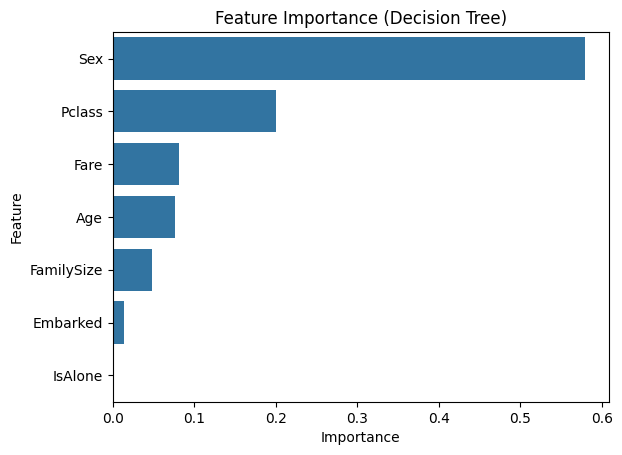

In [47]:
importances = pd.DataFrame({'Feature': features, 'Importance': tree_model.feature_importances_})
importances.sort_values(by='Importance', ascending=False, inplace=True)
sns.barplot(x='Importance', y='Feature', data=importances)
plt.title('Feature Importance (Decision Tree)')
plt.show()

## Business Insights (Interpretation)

In [48]:
print("""
Business Insights:
------------------
1. Gender is the most influential factor — females had a much higher survival rate.
2. Passengers in 1st class had better survival chances than 3rd class.
3. Younger passengers tended to survive more often than elderly ones.
4. Passengers traveling alone (IsAlone=1) had lower survival rates.
5. Higher fare correlated with higher survival, indicating wealth-related advantage.
""")


Business Insights:
------------------
1. Gender is the most influential factor — females had a much higher survival rate.
2. Passengers in 1st class had better survival chances than 3rd class.
3. Younger passengers tended to survive more often than elderly ones.
4. Passengers traveling alone (IsAlone=1) had lower survival rates.
5. Higher fare correlated with higher survival, indicating wealth-related advantage.

